In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import pyodbc
from sqlalchemy import create_engine
import seaborn as sns

In [42]:
server = "localhost" 
database = "DEP1_DWH"
engine = create_engine(f"mssql+pyodbc://@{server}/{database}?driver=ODBC+Driver+17+for+SQL+Server&trusted_connection=yes")

In [43]:
query = """
SELECT 
    u.UserKey,
    u.PVInstallationIndicator,
    u.ElectricVehicleIndicator,
    u.HeatPumpIndicator,
    SUM(e.ConsumptionVolume_kWh) as TotalConsumption
FROM 
    DimUser u
JOIN 
    FactEnergyUsage e ON u.UserKey = e.UserKey
GROUP BY 
    u.UserKey, u.PVInstallationIndicator, u.ElectricVehicleIndicator, u.HeatPumpIndicator
"""

In [44]:
user_consumption_df = pd.read_sql(query, engine)

In [45]:
def determine_user_type(row):
    if row['PVInstallationIndicator'] == 1 and row['ElectricVehicleIndicator'] == 0 and row['HeatPumpIndicator'] == 0:
        return 'PVInstallation'
    elif row['PVInstallationIndicator'] == 0 and row['ElectricVehicleIndicator'] == 0 and row['HeatPumpIndicator'] == 0:
        return 'No PVInstallation'
    elif row['PVInstallationIndicator'] == 1 and row['ElectricVehicleIndicator'] == 0 and row['HeatPumpIndicator'] == 1:
        return 'PVInstallation and HeatPump'
    elif row['PVInstallationIndicator'] == 1 and row['ElectricVehicleIndicator'] == 1 and row['HeatPumpIndicator'] == 0:
        return 'PVInstallation and Electrical Vehicle'
    elif row['PVInstallationIndicator'] == 0 and row['ElectricVehicleIndicator'] == 1 and row['HeatPumpIndicator'] == 0:
        return 'No PVInstallation however Electrical Vehicle'
    else:
        return 'Other'

In [46]:
user_consumption_df['TypeUser'] = user_consumption_df.apply(determine_user_type, axis=1)

In [47]:
colors = {
    'PVInstallation': '#1f77b4',  # blauw
    'No PVInstallation': '#ff7f0e',  # oranje
    'PVInstallation and HeatPump': '#2ca02c',  # groen
    'PVInstallation and Electrical Vehicle': '#d62728',  # rood
    'No PVInstallation however Electrical Vehicle': '#9467bd'  # paars
}

In [48]:
plt.figure(figsize=(12, 6))

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

C:\Users\jaakd\AppData\Local\Temp\ipykernel_2076\1091158674.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


<Axes: xlabel='TotalConsumption', ylabel='TypeUser'>

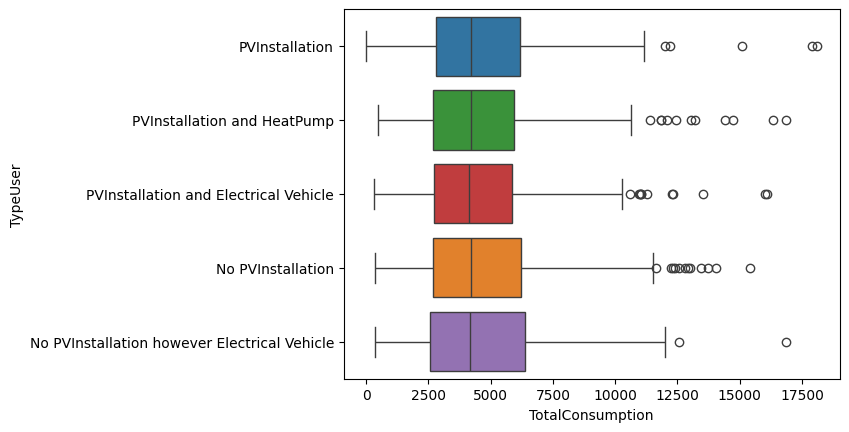

In [49]:
sns.boxplot(
    x='TotalConsumption',
    y='TypeUser',
    data=user_consumption_df,
    orient='h',
    palette=colors
)

In [50]:
avg_consumption_by_type = user_consumption_df.groupby('TypeUser')['TotalConsumption'].mean().reset_index()

avg_consumption_by_type = avg_consumption_by_type.sort_values('TotalConsumption')

avg_consumption_by_type['RelativeDifference'] = avg_consumption_by_type['TotalConsumption'].pct_change() * 100

print("Gemiddeld verbruik per gebruikerstype met relatieve verschillen:")
print(avg_consumption_by_type[['TypeUser', 'TotalConsumption', 'RelativeDifference']].to_string(index=False))

Gemiddeld verbruik per gebruikerstype met relatieve verschillen:
                                    TypeUser  TotalConsumption  RelativeDifference
       PVInstallation and Electrical Vehicle       4560.963833                 NaN
                              PVInstallation       4710.628300            3.281422
                 PVInstallation and HeatPump       4784.892267            1.576519
                           No PVInstallation       4808.662533            0.496777
No PVInstallation however Electrical Vehicle       4972.756500            3.412466
